# Report Kaggle Challenge - IMA205 - Ilian Benaïssa-Lejay

# import libraries

In [7]:
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import tensorflow as tf
from sklearn.pipeline import make_pipeline
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import cv2
import numpy as np
import torch
from torchvision import transforms, models




# Loading and exploring the data

Les deux prochaines fonction m'ont permis de créer des folder ne contenant uniquement les images sans leur segmentation. J'ai donc créer deux dossier '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Test/Test_wo_seg' et '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_wo_seg'. 

J'ai séparé les images segmentées des autres pour me permettre d'entrainer un CNN sur les images brutes.

In [61]:
import os
import shutil

def parcourir_et_copier(source_dir, dest_dir):
    
    # Parcourir le dossier source
    for root, dirs, files in os.walk(source_dir):
        for filename in files:
            # Vérifier si le fichier est un .jpg ou un .png
            if filename.endswith('.jpg'):
                shutil.copy(os.path.join(root, filename), os.path.join(dest_dir, filename))
                
# spécifier les chemins 
source_directory = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Test/Test'
destination_directory = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Test/Test_wo_seg'

parcourir_et_copier(source_directory, destination_directory)

In [ ]:
import os
import shutil

def parcourir_et_copier(source_dir, dest_seg_dir, dest_notseg_dir):
    

    # Parcourir le dossier source
    for root, dirs, files in os.walk(source_dir):
        for filename in files:
            # Vérifier si le fichier est un .jpg ou un .png
            if filename.endswith('.png'):
                shutil.copy(os.path.join(root, filename), os.path.join(dest_seg_dir, filename))
                filename_without_seg = filename.replace('_seg.png', '.jpg')
                print(filename_without_seg)
                shutil.copy(os.path.join(root,filename_without_seg),os.path.join(dest_notseg_dir,filename_without_seg))

# les chemins
source_directory = 'C:/Users/SURFACE/Desktop/Telecom_2A/IMA/S2/IMA205/KaggleChallenge/ima205-challenge-2024/Train/Train'
destination_seg_directory = 'C:/Users/SURFACE/Desktop/Telecom_2A/IMA/S2/IMA205/KaggleChallenge/ima205-challenge-2024/Train/Train_seg'
destination_notseg_directory = 'C:/Users/SURFACE/Desktop/Telecom_2A/IMA/S2/IMA205/KaggleChallenge/ima205-challenge-2024/Train/Train_notseg'

parcourir_et_copier(source_directory, destination_seg_directory, destination_notseg_directory)

Ici, je regarde simplement les structures des données : le nombre d'image par dossier, le format des fichiers cvs, le nombre d'image ayant une segmentation.


In [37]:
# Chemin vers les dossiers
test_folder = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Test/Test'
train_folder = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train'

# Chemin vers les fichiers CSV
metadata_test_file = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/metadataTest.csv'
metadata_train_file = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/metadataTrain.csv'
sample_submission_file = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/SampleSubmission.csv'

# Lire les fichiers CSV avec panda
metadata_test_df = pd.read_csv(metadata_test_file)
metadata_train_df = pd.read_csv(metadata_train_file)
sample_submission_df = pd.read_csv(sample_submission_file)

# Parcourir les fichiers dans le dossier de test
test_image_files = [f for f in os.listdir(test_folder) if f.endswith('.jpg')]
test_segmentation_files = [f for f in os.listdir(test_folder) if f.endswith('.png')]


# Parcourir les fichiers dans le dossier d'entraînement
train_image_files = [f for f in os.listdir(train_folder) if f.endswith('.jpg')]
train_segmentation_files = [f for f in os.listdir(train_folder) if f.endswith('.png')]

# Afficher les informations
print("Nombre d'images de test:", len(test_image_files))
print("Nombre d'images de test avec segmentation:", len(test_segmentation_files))
print("Nombre d'images d'entraînement:", len(train_image_files))
print("Nombre d'images d'entraînement avec segmentation:", len(train_segmentation_files))

# Afficher les premières lignes 
print("Metadata Test:")
print(metadata_test_df.head())
print("Metadata Train:")
print(metadata_train_df.head())
print("Sample Submission:")
print(sample_submission_df.head())


Nombre d'images de test: 6333
Nombre d'images de test avec segmentation: 648
Nombre d'images d'entraînement: 18998
Nombre d'images d'entraînement avec segmentation: 1945
Metadata Test:
             ID     SEX   AGE         POSITION
0  ISIC_0055289  female  50.0  lower extremity
1  ISIC_0062682    male  65.0  lower extremity
2  ISIC_0057706  female  75.0              NaN
3  ISIC_0031702    male  70.0        head/neck
4  ISIC_0069272    male  60.0  lower extremity
Metadata Train:
             ID  CLASS     SEX   AGE         POSITION
0  ISIC_0028766      2    male  30.0              NaN
1  ISIC_0071222      8    male  85.0  lower extremity
2  ISIC_0069434      3    male  85.0        head/neck
3  ISIC_0062098      1    male  55.0        head/neck
4  ISIC_0057224      8  female  45.0  lower extremity
Sample Submission:
             ID  CLASS
0  ISIC_0055289      8
1  ISIC_0062682      2
2  ISIC_0057706      5
3  ISIC_0031702      6
4  ISIC_0069272      4


On affiche quelques images choisies aléatoirement pour voir à quoi elles ressemblent.

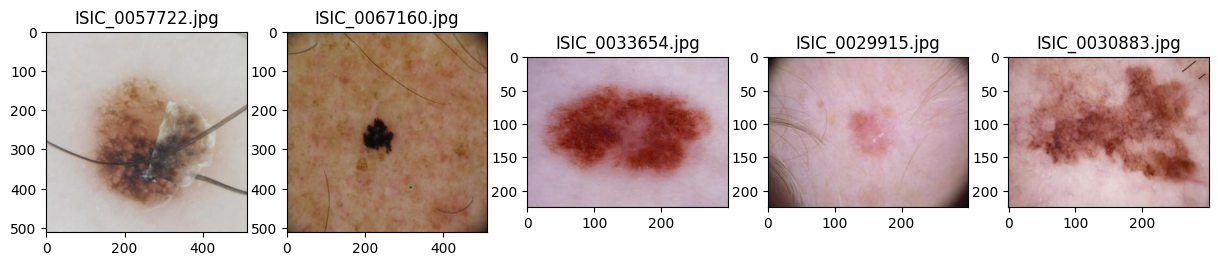

In [19]:
# Select a random sample of images
num_images = 5
random_indices = random.sample(range(len(test_image_files)), num_images)

# Display the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, index in enumerate(random_indices):
    image_path = os.path.join(test_folder, test_image_files[index])
    image = imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(test_image_files[index])

plt.show()


On cherche a faire un histogramme des dimmensions des images pour savoir l'entrée de notre modèle.

Hauteur minimale: 225
Hauteur maximale: 512
Largeur minimale: 288
Largeur maximale: 512


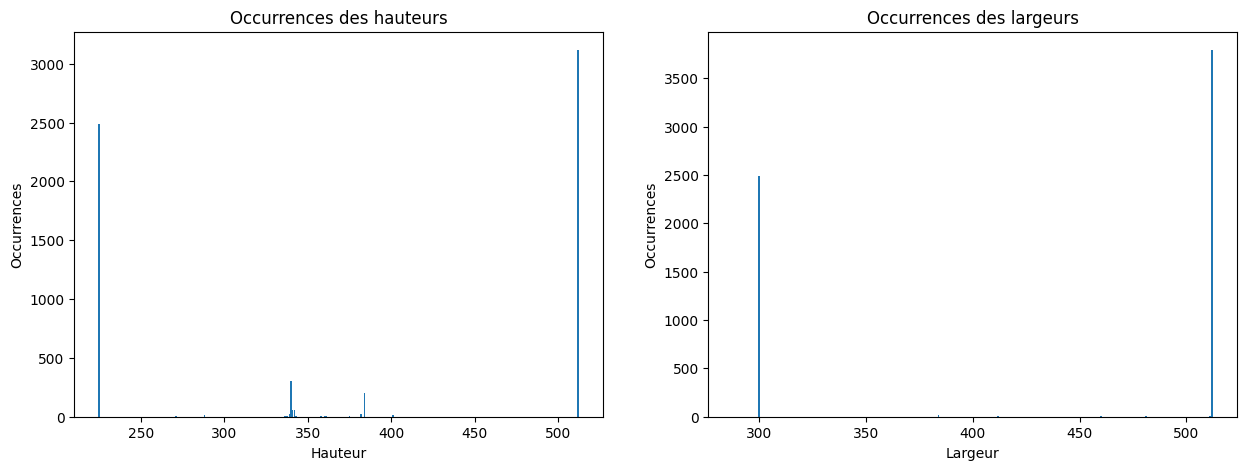

In [20]:
indices = np.arange(len(test_image_files))
heights = []
widths = []

# Display the images
for i, index in enumerate(indices):
    image_path = os.path.join(test_folder, test_image_files[index])
    image = imread(image_path)
    height, width, _ = image.shape
    heights.append(height)
    widths.append(width)

print("Hauteur minimale:", np.min(heights))
print("Hauteur maximale:", np.max(heights))
print("Largeur minimale:", np.min(widths))
print("Largeur maximale:", np.max(widths))

min_height = np.min(heights)
max_height = np.max(heights)
min_width = np.min(widths)
max_width = np.max(widths)

occurrences_height = []

for h in range(min_height, max_height + 1):
    occurrences = np.sum(np.array(heights) == h)
    occurrences_height.append(occurrences)

occurrences_width = []

for w in range(min_width, max_width + 1):
    occurrences = np.sum(np.array(widths) == w)
    occurrences_width.append(occurrences)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].bar(range(min_height, max_height + 1), occurrences_height)
axes[0].set_title("Occurrences des hauteurs")
axes[0].set_xlabel("Hauteur")
axes[0].set_ylabel("Occurrences")
axes[1].bar(range(min_width, max_width + 1), occurrences_width)
axes[1].set_title("Occurrences des largeurs")
axes[1].set_xlabel("Largeur")
axes[1].set_ylabel("Occurrences")
plt.show()

    
    



On voit ici que les tailles des images ne sont pas uniforme mais surtout répartie en deux formats principaux. Cependant dans le reste du projet je les met toutes au format 224*224 car c'est l'entrée de nombreux réseau pré-entrainé comme Resnet.

On va maintenant voir la répartition des classes dans le dataset. Car il est important d'entrainer notre modèle en prenant compte de cette répartition afin de ne pas faire de l'overfit par exemple.

[3391, 9657, 2492, 650, 1968, 179, 190, 471]


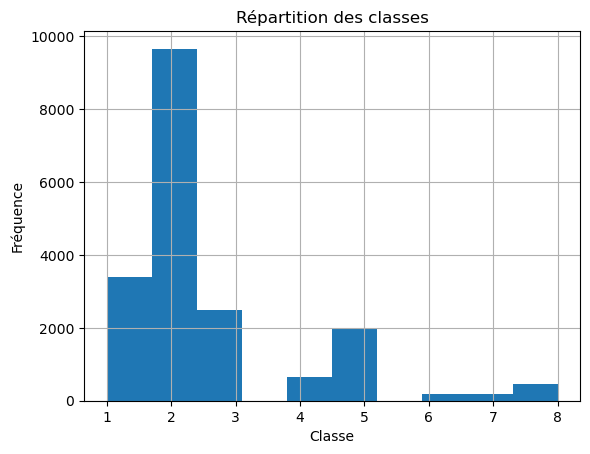

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/metadataTrain.csv')

# Obtenir la répartition des classes
class_distribution = df['CLASS'].value_counts()

repartition_list = class_distribution.sort_index().tolist()

print(repartition_list)
# Créer un histogramme de la colonne 'CLASS'
df['CLASS'].hist()

plt.title('Répartition des classes')
plt.xlabel('Classe')
plt.ylabel('Fréquence')

plt.show()

Ici, on voit que la classe 2 est surreprésentée il y a presque 3 fois plus d'image de cette classe que de la classe 1 (qui est la deuxième plus représentée). Il faudra donc prendre en compte cette répartition lors de l'entrainement de notre modèle.

# Preprocessing (removing hairs, segmentation)

Ici nous voyons par exemple que l'image 'ISIC_0024527.jpg' contient des poils qui peuvent être un problème pour le diagnostic de mélanome. Nous allons donc utiliser un filtre morphologique de fermeture pour supprimer les poils, comme on peut le lire dans l'article H. Ganster, P. Pinz, R. Rohrer, E. Wildling, M. Binder and H. Kittler, "Automated melanoma recognition,".


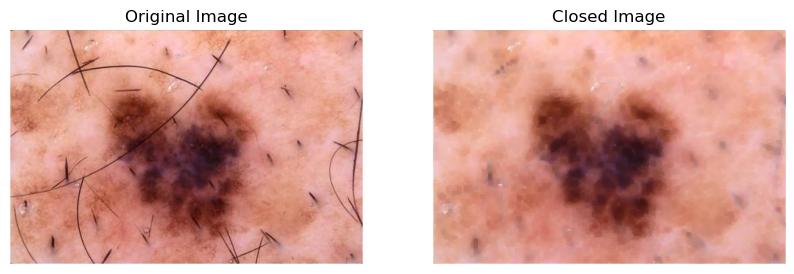

In [54]:

image_path = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train/ISIC_0000164.jpg'
hairy_melanoma = imread(image_path)

struc_elmt = np.ones((5,5))
# Apply closing operation on the gray level image
gray_image_closed = cv2.morphologyEx(hairy_melanoma, cv2.MORPH_CLOSE, struc_elmt)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(hairy_melanoma, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(gray_image_closed, cmap='gray')
axes[1].set_title('Closed Image')
axes[1].axis('off')
plt.show()



It seems to work pretty well by preserving the edges of the lesion, the color of the lesion and removing the hairs.

In [55]:
def dull_razor(hairy_melanoma): 
    struc_elmt = np.ones((5,5))
    # Apply closing operation on the gray level image
    gray_image_closed = cv2.morphologyEx(hairy_melanoma, cv2.MORPH_CLOSE, struc_elmt)
    return gray_image_closed


Pour ce qui est de la fonction resize elle sera appliqué directement à l'entrée du CNN.

# CNN pour segmentation

Afin d'extraire des features on souhaite pouvoir avoir un mask pour toutes les images, car il pourra nous être utile pour déetrminer la symétrie de la lésion par exemple.

In [11]:
folder_train_notseg = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_notseg'
folder_train_seg = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_seg'


Pour entraîner un CNN capable de segmenter les images nous allons utiliser l'architechture Unet. C'est une architecture qui a fait ses preuves pour la segmentation d'image. Avec comme fonction de loss la dice loss et l'optimiseur Adam.
La première étape est de créer deux listes, l'une comportant les images et l'autre les masks. On va ensuite les transformer en array numpy pour pouvoir les utiliser dans notre modèle.

In [ ]:
# Paramètres
img_rows = 256
img_cols = 256
smooth = 0
epochs = 10
batch_size = 64

# Fonctions utilitaires
def load_train_data(img_dir, seg_dir, img_rows, img_cols):
    X_train, Y_train = [], []
    for img_name in os.listdir(img_dir):
        if img_name.endswith(".jpg"):
            img_path = os.path.join(img_dir, img_name)
            seg_path = os.path.join(seg_dir, img_name.replace(".jpg", "_seg.png"))

            img = Image.open(img_path).resize((img_rows, img_cols))
            img = np.asarray(img) / 255.

            seg = Image.open(seg_path).convert('L').resize((img_rows, img_cols))
            seg = np.asarray(seg)
            seg = seg.reshape((seg.shape[0], seg.shape[1], 1))

            X_train.append(img)
            Y_train.append(seg)

    return np.array(X_train), np.array(Y_train)

def dice_coef(y_true, y_pred):
    y_true_f = tf.cast(tf.reshape(y_true, shape=[-1]), dtype=tf.float32)
    y_pred_f = tf.reshape(y_pred, shape=[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Charger les données
img_dir = folder_train_notseg
seg_dir = folder_train_seg

X_train, Y_train = load_train_data(img_dir, seg_dir, img_rows, img_cols)

# Créer le modèle U-Net
inputs = layers.Input((img_rows, img_cols, 3))
c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
p3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
p4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = layers.concatenate([u6, c4], axis=-1)
c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = layers.concatenate([u7, c3], axis=-1)
c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = layers.concatenate([u8, c2], axis=-1)
c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = layers.concatenate([u9, c1], axis=-1)
c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = models.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

# Entraîner le modèle
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Sauvegarder le modèle
model.save('/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/segmentation_model.h5')

Ici on peut voir qu'il y a eu un problème lors de l'entraînement car j'ai obtenue une loss négative et un dice_coeff supérieur à 1. Mais j'ai été curieux de voir ce que cela avait donné. En testant le modèle sur les images j'ai vu que j'obtenais des bons résultats je n'ai donc pas retravailler cette anomalie.

Il fallait d'abord mettre l'image au bon format pour utiliser le modèle de segmentation. J'ai donc redimensionné l'image en 256*256 et normalisé les valeurs des pixels. Puis j'ai rajouter une dimension car le modèle attend un batch d'image.

In [1]:
import numpy as np
from PIL import Image


img_rows = 256
img_cols = 256

def prepare_image(image_path, img_rows, img_cols):
    img = Image.open(image_path).resize((img_rows, img_cols))
    img = np.asarray(img) / 255.
    img = np.expand_dims(img, axis=0)  # Ajoute une dimension pour correspondre à la forme attendue du modèle CNN
    return img


Test du CNN, on charge d'abord le modele.

In [ ]:
from tensorflow.keras import models
with tf.device('/cpu:0'):
    path_model =  '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/segmentation_model.h5'
    model_seg = models.load_model(path_model)


In [17]:
model_seg.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_38[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_40[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_42[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_44[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_11… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_46[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │    524,544 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,760,099 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Ici, j'ai fait une fonction qui permet de recevoir l'image à la bonne taille et aussi de faire un treshold car mon cnn renvoyait en fait des image en niveaux de gris et non en noir et blanc.

In [23]:

def post_process_prediction(image_path, threshold=0.3):
    with tf.device('/CPU:0'):
        image = Image.open(image_path)
        img_width, img_height = image.size
        image_for_cnn = prepare_image(image_path, img_rows, img_cols)
        prediction = model_seg.predict(image_for_cnn)
        prediction = (prediction > 0.3).astype(np.uint8)
        prediction = np.squeeze(prediction)
        prediction = (resize(prediction, (img_height, img_width)) * 255).astype(np.uint8)
    return np.squeeze(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


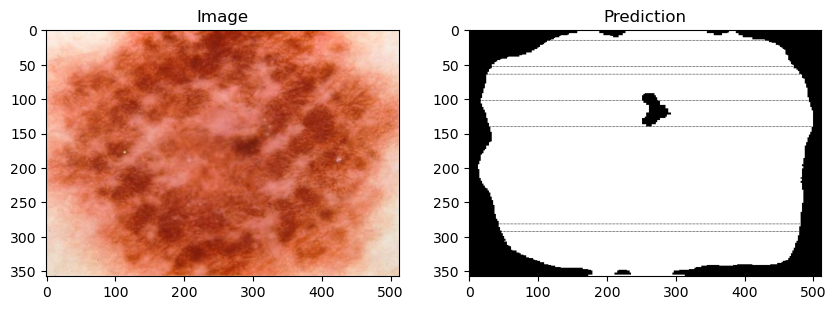

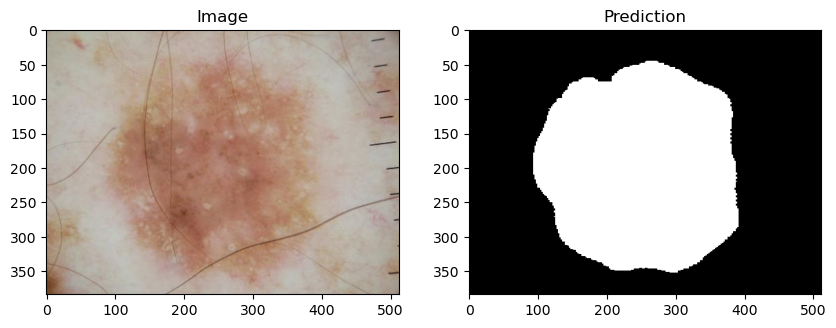

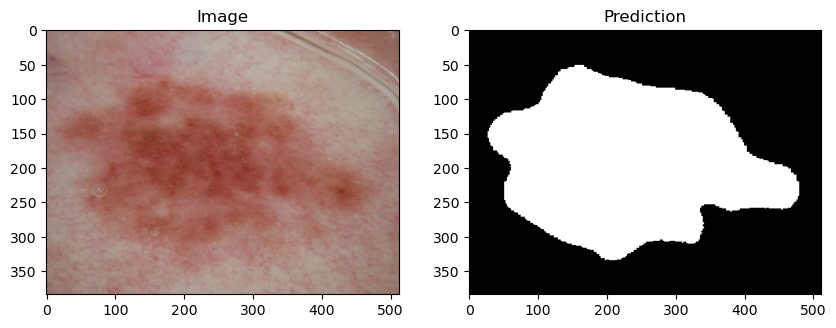

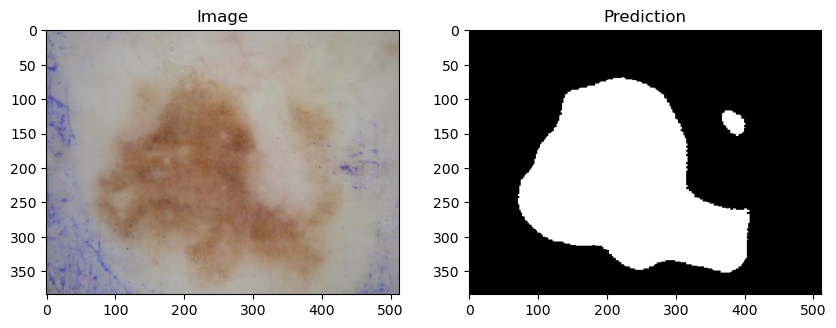

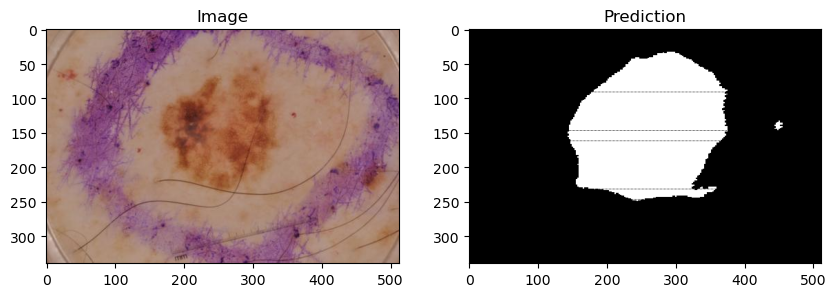

In [24]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Path of the folder containing the images
folder_path = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_notseg'

# List of files in the folder
file_list = os.listdir(folder_path)

num_images = 5

for i in range(num_images):
    # Path of the image
    image_path = os.path.join(folder_path, file_list[i])
    
    # Load the image
    image = Image.open(image_path)


    # prediction
    prediction = post_process_prediction(image_path,threshold=0.4)

    # Plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    # Plot the prediction
    plt.subplot(1, 2, 2)
    plt.imshow(prediction, cmap='gray')
    plt.title('Prediction')

# Show the plot
plt.show()

En essayant sur des images, j'étais assez satisfait du résultat car on retrouve bien les contours de la lésion. malgrès quelques erreurs.

Ennsuite grâce à ce CNN je voulais pouvoir croper l'image pour en conserver que le melanome sans la peau autour. Je multiplie donc l'image par son masque pixel par pixel.

In [21]:
def image_segmentation(image_path,model_seg, threshold=0.3):
    seg = post_process_prediction(image_path, threshold)
    image = Image.open(image_path)
    image = np.asarray(image)
    seg = np.asarray(seg)
    image = np.where(seg[..., None] > 0, image, 0)
    return image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


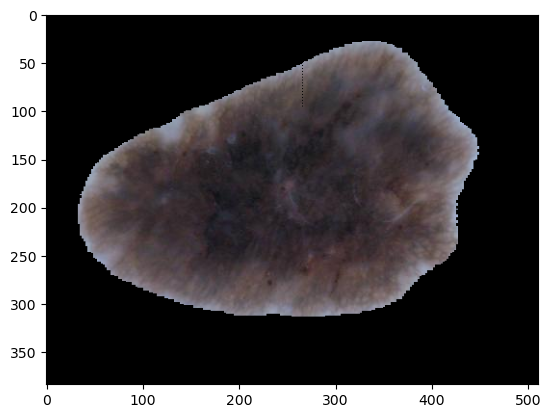

In [22]:
plt.imshow(image_segmentation('/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_notseg/ISIC_0000000.jpg', model_seg))
plt.show()

Le résultat est conforme à ce que j'attendais.

# Création du Dataset 

Je choisis d'utiliser la librairie PyTorch car au vu de l'architecture des données je trouvais plus simple de créer mon propre Dataset, ce que je ne maitrise pas avec keras.
C'est donc ce que je fais dans la prochaine cellule dans laquelle je lie les images à leurs classes grâce à getitem en parcours le fichier csv à la recherche du nom de la photo.
Puis j'applique à toutes les images le fonction transform qui normalise, transforme en tenseur et change la taille pour être en accord avec les entrés du CNN Resnet que j'utilise ensuite.
Il y a aussi une autre transformation qui s'appelle transformbis, que j'ai tenté d'utilisé pour faire de l'augmentation de donnée, mais finalement je n'ai pas gardé cette transformation car j'obtenais de moins bon résultat avec.

Enfin je prend aussi en compte la répartition des classes dans le train set pour créer un dataloader sampler qui à autant d'image de chacune des classes. J'ai décidé d'utiliser un sampler plutôt que que des poids associer à chaque classe car cela me permettait de contrôler facilement la répartiton à la main.

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, metadata_file, transform=None):
        self.image_folder = image_folder
        self.metadata = pd.read_csv(metadata_file)
        self.transform = transform
        


    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx): 
        img_name = os.path.join(self.image_folder, self.metadata.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        
        
        label = self.metadata.loc[idx, "CLASS"] - 1  # Classes are 1-indexed, so we subtract 1 to make them 0-indexed
        return image, label

transformbis = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #  pretrained models with ImageNet normalization
])


image_folder = "/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_wo_seg"
metadata_file = "/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/metadataTrain.csv"

dataset = CustomDataset(image_folder, metadata_file, transform=transform)

batch_size = 32
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
class_sample_count = [3391, 9657, 2492, 650, 1968, 179, 190, 471]
weight = 1. / torch.tensor(class_sample_count, dtype=torch.float32)
train_targets = np.array(dataset.metadata['CLASS'].values)[train_dataset.indices] - 1
train_weights = weight[train_targets]
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))



# Create data loaders for training and validation with WeightedRandomSampler
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


Affichons la répartion en classe pour nous assurer du résultat.

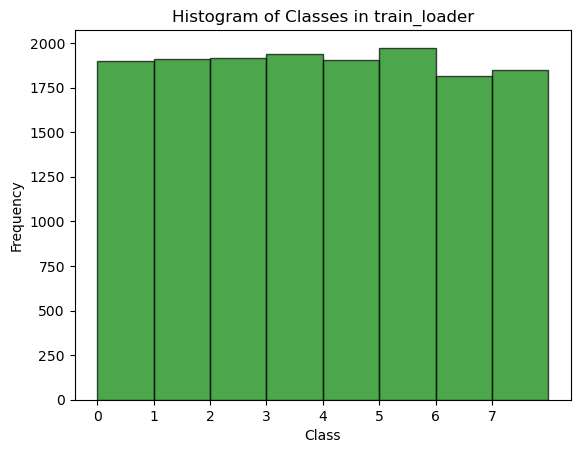

In [25]:

labels = []
for _, label in train_loader:
    labels.extend(label.tolist())

# Plot the histogram
plt.hist(labels, bins=range(9), alpha=0.7, color='g', edgecolor='black')
plt.title('Histogram of Classes in train_loader')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(8))
plt.show()

C'est tout bon !

# Entrainement de ResNet18

Comme je l'ai précisé je compte travailler avec un achitecture préentrainée et plus précisement resnet18 pour plusieurs raisons. ResNet18 est une architecture CNN efficace et populaire, elle offre un bon équilibre entre précision et un temps d'entrainement pas trop long. De plus, le transfert d'apprentissage à partir de poids pré-entraînés peut améliorer les performances, surtout avec des ensembles de données plus petits. Enfin, ResNet a été utilisé avec succès dans des applications de santé similaires.

Dans la cellule suivante j'adapte simplement le nombre de sortie du réseau pour correspondre à un vecteur de taille 8 en ajoutant une couche linéaire de bonne taille.

In [10]:
# Charger l'architecture ResNet pré-entraînée
model = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modifier la dernière couche pour qu'elle corresponde à notre nombre de classes (8)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

model = model.to(device)

print(model)
print(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Pour ce qui est de l'entraînement du modèle j'ai suivi la méthode du TP CNN_classification car elle est classique et permet de se rendre compte de l'avancée epoch par epoch

In [11]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
import torch
def vector_to_class(x):
  # BEGIN STUDENT CODE
  x = nn.Softmax(dim=1)(x)
  y = torch.argmax(x, dim=1)
  # END STUDENT CODE
  return y

In [13]:
def cnn_accuracy(predict,labels):
  # BEGIN STUDENT CODE
  accuracy = np.mean(predict == labels)
  # END STUDENT CODE
  return accuracy

In [ ]:
train_losses=[]
valid_losses=[]
n_epochs = 10

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(train_loader):
    # pass the samples through the network
    imgs = imgs.to(device)  # Move input data to the same device as the model
    labels = labels.to(device)  # Move labels to the same device as the model
    predict = model(imgs)
    predict = model(imgs) # FILL IN STUDENT
    

    # apply loss function
    loss = criterion(predict, labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

In [29]:
#save the model
torch.save(model.state_dict(), '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class.pth')


Maintenant que mon modèle est entrainé je souhaite l'utiliser pour faire des submissions sur Kaggle, je créer donc un data set sans label qui contient les images à tester

Je charge le modèle

In [ ]:
model_path = '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class.pth'
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)
model.load_state_dict(torch.load(model_path))

model = model.to(device)

Accuracy: 75.58%


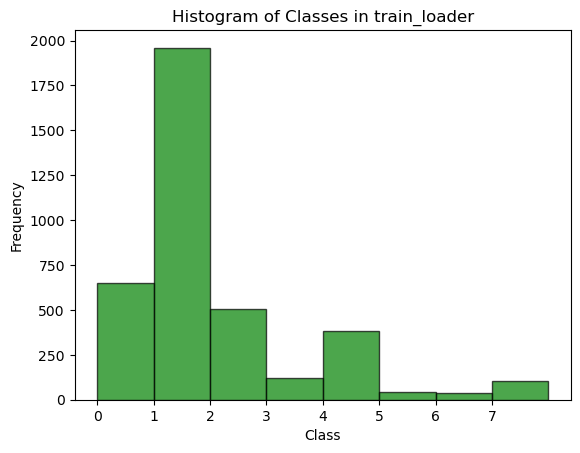

In [25]:
def calculate_accuracy(model, val_loader):
    correct = 0
    total = 0
    labels_for_hist = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    

# Plot the histogram

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_for_hist.extend(labels.tolist())

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
             

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    return accuracy, labels_for_hist

accuracy, labels = calculate_accuracy(model, val_loader)

print(f"Accuracy: {accuracy:.2f}%")
plt.hist(labels, bins=range(9), alpha=0.7, color='g', edgecolor='black')
plt.title('Histogram of Classes in train_loader')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(8))
plt.show()

On obtient une assez bonne accuracy de 75.58 sur val set

# CNN avec resnet50

Après avoir entrainé un modèle avec resnet18 je me suis dit que je pourrais essayer avec un modèle plus complexe pour voir si cela améliore les performances. J'ai donc utilisé resnet50. en suivant exactement les mêmes étapes

In [ ]:
# Charger l'architecture ResNet pré-entraînée

from torchvision import models
import pandas as pd
from PIL import Image

model = models.resnet50(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modifier la dernière couche pour qu'elle corresponde à notre nombre de classes (8)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

model = model.to(device)

# Déplacer le modèle sur GPU si disponible

print(model)
print(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses=[]
valid_losses=[]
n_epochs = 10

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(train_loader):
    # pass the samples through the network
    imgs = imgs.to(device)  # Move input data to the same device as the model
    labels = labels.to(device)  # Move labels to the same device as the model
    predict = model(imgs)
    predict = model(imgs) # FILL IN STUDENT
    print(predict.shape)
    print(predict)
    print(labels)
    print(labels.shape)

    # apply loss function
    loss = criterion(predict, labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

#save the model
torch.save(model.state_dict(), '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_resnet50.pth')


/home/infres/ibenaissa-22/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 70.42%


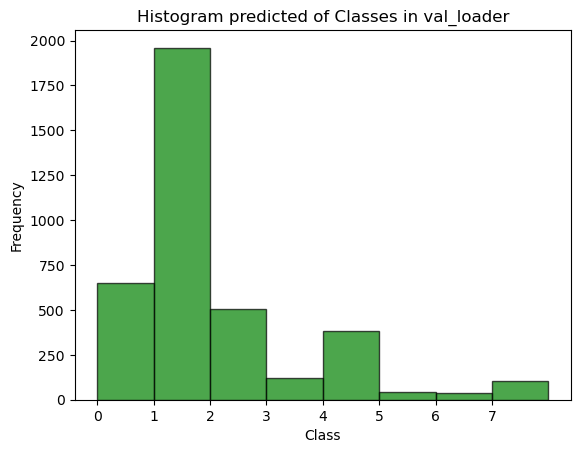

In [16]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)
model.load_state_dict(torch.load('/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_resnet50.pth'))
model = model.to(device)

accuracy, labels = calculate_accuracy(model, val_loader)

print(f"Accuracy: {accuracy:.2f}%")
plt.hist(labels, bins=range(9), alpha=0.7, color='g', edgecolor='black')
plt.title('Histogram predicted of Classes in val_loader')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(8))
plt.show()

J'obtiens cependant une accuracy moins bonne qu'avec resnet18. Cela peut être du à un overfitting car le modèle est plus complexe et donc plus sujet à l'overfitting. cependant la baisse de précision n'est pas trop grande 5% ce qui est acceptable.

# VGG

Je me suis dit que je pourrais essayer avec un autre modèle pré-entrainé, j'ai donc choisi VGG16. J'ai suivi les mêmes étapes que pour les autres modèles.

In [ ]:
class VGG8(nn.Module):
    def __init__(self):
        super(VGG8, self).__init__()
        # Charger le modèle VGG-16 pré-entraîné
        vgg16 = models.vgg16(pretrained=True)
        
        # Geler les poids des couches convolutionnelles pour empêcher l'entraînement
        for param in vgg16.parameters():
            param.requires_grad = False
        
        # Prendre les couches convolutionnelles du modèle VGG-16 pré-entraîné
        self.features = vgg16.features
        
        # Remplacer la dernière couche entièrement connectée
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),  # 25088 est la taille de l'entrée de la dernière couche
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 8)  # 8 classes de sortie
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Créer une instance du modèle
model = VGG8()


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modifier la dernière couche pour qu'elle corresponde à notre nombre de classes (8)


model = model.to(device)

# Déplacer le modèle sur GPU si disponible

print(model)
print(device)

train_losses=[]
valid_losses=[]
n_epochs = 10

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(train_loader):
    # pass the samples through the network
    imgs = imgs.to(device)  # Move input data to the same device as the model
    labels = labels.to(device)  # Move labels to the same device as the model
    predict = model(imgs)
    predict = model(imgs) # FILL IN STUDENT
    print(predict.shape)
    print(predict)
    print(labels)
    print(labels.shape)

    # apply loss function
    loss = criterion(predict, labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

#save the model
torch.save(model.state_dict(), '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_vgg16_2.pth')


/home/infres/ibenaissa-22/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/ibenaissa-22/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 61.87%


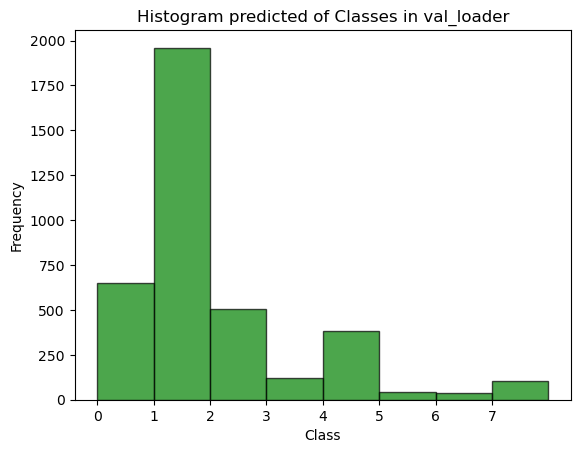

In [26]:
model_path_vgg8 = '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_vgg16_2.pth'
model_vgg8 = VGG8()
model_vgg8.load_state_dict(torch.load(model_path_vgg8))
model_vgg8 = model_vgg8.to(device)

accuracy, labels = calculate_accuracy(model_vgg8, val_loader)

print(f"Accuracy: {accuracy:.2f}%")
plt.hist(labels, bins=range(9), alpha=0.7, color='g', edgecolor='black')
plt.title('Histogram predicted of Classes in val_loader')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(8))
plt.show()

On obtien ici 62.5% d'accuracy sur le val set. C'est moins bon que les deux autres modèles mais cela reste acceptable.

# DenseNet

Cette fois avec DenseNet, maintenant on connait la recette.

In [ ]:



# Modifier la dernière couche pour qu'elle corresponde à notre nombre de classes (8)

densenet = torchvision.models.densenet121(pretrained=True).to(device)

# Modify the fully connected layer for classification
densenet.classifier = nn.Linear(in_features=1024, out_features=8)

model = densenet


model = model.to(device)

# Déplacer le modèle sur GPU si disponible

print(model)
print(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


train_losses=[]
valid_losses=[]
n_epochs = 10

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  for batch_idx, (imgs, labels) in enumerate(train_loader):
    # pass the samples through the network
    imgs = imgs.to(device)  # Move input data to the same device as the model
    labels = labels.to(device)  # Move labels to the same device as the model
    predict = model(imgs)
    predict = model(imgs) # FILL IN STUDENT
    print(predict.shape)
    print(predict)
    print(labels)
    print(labels.shape)

    # apply loss function
    loss = criterion(predict, labels) # FILL IN STUDENT
    # set the gradients back to 0
    optimizer.zero_grad() # FILL IN STUDENT
    # backpropagation
    loss.backward() # FILL IN STUDENT
    # parameter update
    optimizer.step() # FILL IN STUDENT
    # compute the train loss
    train_loss += loss.item()
    # store labels and class predictions
    all_labels.extend(labels.tolist())
    all_predicted.extend(vector_to_class(predict).tolist())

  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/len(train_loader)))

  # calculate accuracy
  print('Accuracy:{:.4f}'.format(cnn_accuracy(np.array(all_predicted),np.array(all_labels))))

#save the model
torch.save(model.state_dict(), '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_densenet.pth')


/home/infres/ibenaissa-22/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/ibenaissa-22/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy: 75.58%


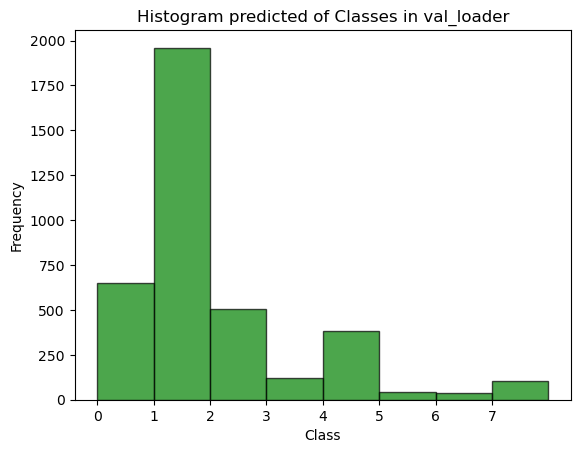

In [28]:
model_path_densenet = '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_densenet.pth'
model_densenet = models.densenet121(pretrained=True)
model_densenet.classifier = nn.Linear(in_features=1024, out_features=8)
model_densenet.load_state_dict(torch.load(model_path_densenet))
model_densenet = model_densenet.to(device)
accuracy, labels = calculate_accuracy(model, val_loader)

print(f"Accuracy: {accuracy:.2f}%")
plt.hist(labels, bins=range(9), alpha=0.7, color='g', edgecolor='black')
plt.title('Histogram predicted of Classes in val_loader')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(8))
plt.show()

# Ensemble learning

Après avoir entrainé plusieurs modèles, je me suis dit que je pourrais essayer de faire un ensemble learning pour voir si cela améliore les performances. J'ai donc utilisé les 4 modèles précédents pour faire un vote majoritaire. 
Je me suis rendu compte plus tard que j'aurais pu sommer les probabilités de chaque modèle pour obtenir une probabilité finale. Cependant, je n'ai pas eu le temps de le faire.
Je procède donc à un vote majoritaire, pondéré par la précision de chaque modèle, ce qui représente la confiance que l'on a en ce modèle.

In [ ]:


model_path_resnet18 = '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class.pth'
model_path_resnet50 = '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_resnet50.pth'
model_path_vgg8 = '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_vgg16_2.pth'
model_path_densenet = '/home/infres/ibenaissa-22/KaggleChallenge/models/CNNs/cnn_model_for_class_densenet.pth'

model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, 8)
model_resnet18.load_state_dict(torch.load(model_path_resnet18))
model_resnet18 = model_resnet18.to(device)

model_resnet50 = models.resnet50(pretrained=True)
num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_ftrs, 8)
model_resnet50.load_state_dict(torch.load(model_path_resnet50))
model_resnet50 = model_resnet50.to(device)

model_vgg8 = VGG8()
model_vgg8.load_state_dict(torch.load(model_path_vgg8))
model_vgg8 = model_vgg8.to(device)


model_densenet = models.densenet121(pretrained=True).to(device)
model_densenet.classifier = nn.Linear(in_features=1024, out_features=8)
model_densenet.load_state_dict(torch.load(model_path_densenet))
model_densenet = model_densenet.to(device)

models_list = [model_resnet18, model_resnet50, model_vgg8, model_densenet]

accuracies = [calculate_accuracy(model, val_loader)[0] for model in models_list]
weights_accuracy = [accuracy / sum(accuracies) for accuracy in accuracies]

print(weights_accuracy)



In [31]:
weights = weights_accuracy
print(weights)

[0.2741766109785203, 0.2554653937947494, 0.22357995226730312, 0.24677804295942724]


C'est grâce à cette fonction que je peux retrouver le vote majoritaire de tous les modèles, je somme juste le poids de chaque modèle pour chaque classe et je prend la classe qui a le plus de poids.

In [32]:
def prediction_ensemble(models_list, weights, img):
    ensemble_predictions = torch.zeros((len(models_list), img.size(0)), dtype=torch.long, device=device)
    
    # Iterate through each model
    for i, model in enumerate(models_list):
        # Ensure the model is in evaluation mode
        model.eval()
        # Forward pass
        with torch.no_grad():
            img = img.to(device)
            outputs = model(img)
            # Get predicted labels
            _, predicted = torch.max(outputs, 1)
            ensemble_predictions[i] = predicted
    
    # Weighted majority voting
    weighted_predictions = torch.zeros((img.size(0),), dtype=torch.long, device=device)
    for j in range(img.size(0)):
        votes = torch.zeros((8,), dtype=torch.float, device=device)  # Assuming 8 classes
        for i in range(len(models_list)):
            # Increment vote count for the predicted class
            votes[ensemble_predictions[i, j]] += weights[i]
        # Choose the class with the highest total weight
        weighted_predictions[j] = torch.argmax(votes)
    
    return weighted_predictions


J'ai aussi un peut modifier la fonction qui permettait de calculer la précision du cnn

Accuracy: 80.03%


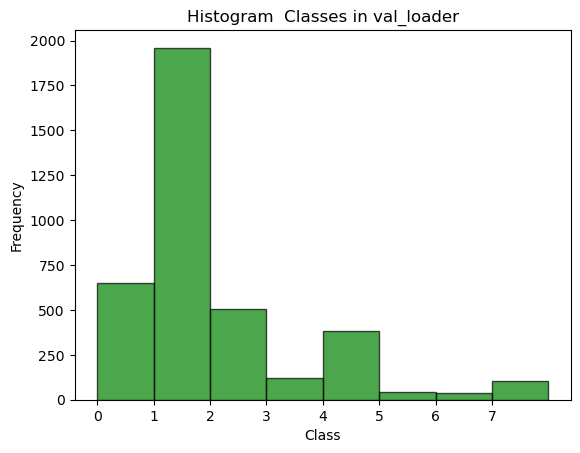

In [34]:
def calculate_accuracy_ensemble(val_loader):
    correct = 0
    total = 0
    labels_for_hist = []
    

# Plot the histogram

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels_for_hist.extend(labels.tolist())

            predicted = prediction_ensemble(models_list,weights, images)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    return accuracy, labels_for_hist

accuracy, labels = calculate_accuracy_ensemble( val_loader)

print(f"Accuracy: {accuracy:.2f}%")
plt.hist(labels, bins=range(9), alpha=0.7, color='g', edgecolor='black')
plt.title('Histogram  Classes in val_loader')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(8))
plt.show()

Et voilà, on obtient une accuracy de 80.5% sur le val set. C'est une amélioration par rapport à tous les modèles précédents. Et c'est aussi la meilleure précision que j'ai pu atteindre.

# ABCD rules 

Je met cette partie à la fin du Rapport car ce n'est pas la méthode finale que j'ai utilisé, cependant je savais l'utilité de l'extraction de feature et je présente donc mes résultats ici.

**Feature symmetry**

By reading the articles, I found that the measure of the asymmetry of the lesion is important for the diagnosis of melanoma. I will therefore use the asymmetry measure.

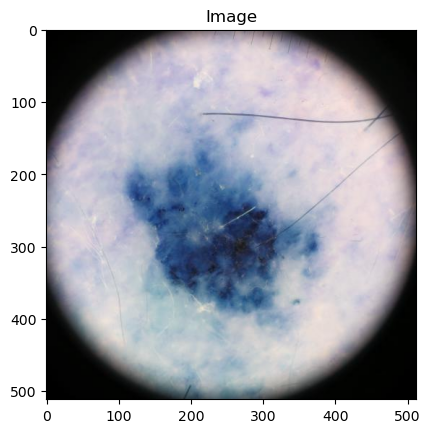

Symmetry: 289.8876897433055


In [38]:
rd_index = random.randint(0, len(train_segmentation_files) - 1)
image_path = os.path.join(train_folder, train_segmentation_files[rd_index])
image_seg = imread(image_path)


# Find contours
contours, _ = cv2.findContours(image_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)  # Assuming the melanoma is the largest contour

# Find centroid
M = cv2.moments(contour)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

# Find corresponding points and measure distances
distances = []
for point in contour:
    dx = point[0, 0] - cX
    dy = point[0, 1] - cY
    corresponding_point = [cX - dx, cY - dy]
    distance = np.sqrt((point[0, 0] - corresponding_point[0])**2 + (point[0, 1] - corresponding_point[1])**2)
    distances.append(distance)

# Measure symmetry
symmetry = np.mean(distances)
plt.imshow(image)
plt.title('Image')
plt.show()

print('Symmetry:', symmetry)

In [78]:
def calculate_symmetry(image_seg):
    contours, _ = cv2.findContours(image_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if contours list is not empty
    if contours:
        contour = max(contours, key=cv2.contourArea) 
        # Find centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0  
        # Calculate symmetry
        left_side = image_seg[:, :cX]
        right_side = image_seg[:, cX:]
        right_side = cv2.flip(right_side, 1)
        min_width = min(left_side.shape[1], right_side.shape[1])
        left_side = left_side[:, :min_width]
        right_side = right_side[:, :min_width]
        return np.sum(np.abs(left_side-right_side))
    else:
        # Handle the case when there are no contours
        return 0  

On test notre fonction sur des images déjà segmentée pour voir si elle marche.

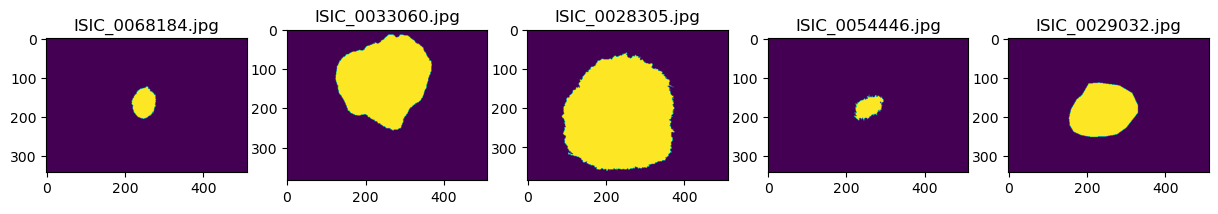

Symmetry of image 1: 67.8129757463221
Symmetry of image 2: 226.35367537721314
Symmetry of image 3: 290.04698177234786
Symmetry of image 4: 62.92180711037904
Symmetry of image 5: 157.33698214723594


In [40]:
# Select a random sample of images
num_images = 5
random_indices = random.sample(range(len(train_segmentation_files)), num_images)

# Display the images and calculate their symmetry
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
symmetry_values = []
for i, index in enumerate(random_indices):
    image_path = os.path.join(train_folder, train_segmentation_files[index])
    image = imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(test_image_files[index])
    
    symmetry = calculate_symmetry(image)
    symmetry_values.append(symmetry)

plt.show()

# Print the symmetry values
for i, symmetry in enumerate(symmetry_values):
    print(f"Symmetry of image {i+1}: {symmetry}")


Les scores paraissent cohérent avec ce que l'on observe. Il faudra néanmoins les normaliser pour les utiliser dans notre modèle.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Score pour les bords irréguliers: 1.506078055515027


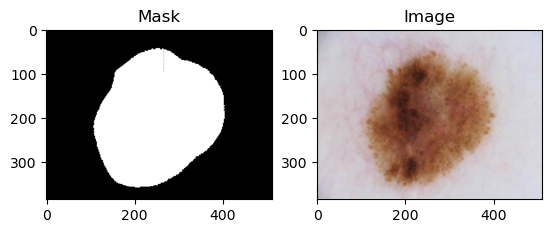

In [69]:
import cv2

import numpy as np
import cv2

def score_bords_irreguliers(lesion_mask):
    eps = 1e-4
    # Calcule le contour de la lésion à partir du masque
    contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lesion_contour = contours[0] if contours else None
    
    if lesion_contour is None:
        return None
    
    # Calcule la superficie totale de la lésion
    area_total = cv2.contourArea(lesion_contour)
    
    # Calcule le périmètre de la lésion
    perimeter = cv2.arcLength(lesion_contour, True)
    
    # Calcule le score pour les bords irréguliers
    compact_index = (perimeter ** 2) / (4 * np.pi * area_total+eps)
    
    return compact_index



#exemple d'utilisation
image_path = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_wo_seg/ISIC_0000008.jpg'
image = imread(image_path)
mask = post_process_prediction(image_path, threshold=0.4)
score = score_bords_irreguliers(mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Image')

print("Score pour les bords irréguliers:", score)


In [47]:


def score_couleur_inegale(mask, image):
    # Appliquer le masque pour obtenir la région du grain de beauté
    mole_region = cv2.bitwise_and(image, image, mask=mask)
    
    # Convertir l'image en niveau de gris
    gray_mole = cv2.cvtColor(mole_region, cv2.COLOR_BGR2GRAY)
    
    # Calculer la variance de la couleur
    variance_score = np.var(gray_mole)
    
    return variance_score

# Exemple d'utilisation de la fonction avec un masque d'image et une image du grain de beauté
image_path = '/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_wo_seg/ISIC_0073227.jpg'
mask = post_process_prediction(image_path, threshold=0.4)
image = cv2.imread(image_path)

score = score_couleur_inegale(mask, image)
print("Score pour la couleur inégale:", score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Score pour la couleur inégale: 2727.2955340137705


In [62]:
def extract_ABC(image_path):
    image_seg = post_process_prediction(image_path, threshold=0.4)
    image = dull_razor(imread(image_path))
    # calculte symmetry
    symmetry = calculate_symmetry(image_seg)
    # calculte irregularity
    irregularity = score_bords_irreguliers(image_seg)
    # calculate color variance
    color_var = score_couleur_inegale(image_seg, image)
    return [symmetry, irregularity, color_var]
    

In [50]:
def extract_metadataTrain(image_path):
    metadataTrain = pd.read_csv('/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/metadataTrain.csv')
    ID = image_path.split('/')[-1].split('.')[0]
    relevant_metadata = metadataTrain[['SEX', 'AGE', 'POSITION']].values.tolist()[0]
    
    return relevant_metadata


Afin d'extraire les features et leurs classes nous utilisons les deux fonctions suivantes.

In [64]:
def all_features(image_path):
    metadata = extract_metadataTrain(image_path)
    ABC = extract_ABC(image_path)
    return metadata + ABC

In [66]:
def get_class(image_path):
    metadataTrain = pd.read_csv('/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/metadataTrain.csv')
    ID = image_path.split('/')[-1].split('.')[0]
    classe = metadataTrain[metadataTrain['ID'] == ID]['CLASS'].values[0]
    
    return classe

Nous allons maintenant créer un fichier csv afin de répertorier toutes les données

In [ ]:

# Chemin du dossier contenant les images
image_folder = "/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Train/Train_wo_seg"

# Chemin du fichier CSV à créer
csv_file = "/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/features.csv"

# Liste pour stocker les données
data = []

# Parcourir les fichiers dans le dossier d'images
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_folder, filename)
        ID = image_path.split('/')[-1].split('.')[0]
        # Extraire les caractéristiques de l'image
        features = all_features(image_path)
        # Obtenir la classe de l'image
        image_class = get_class(image_path)
        # Ajouter les caractéristiques et la classe à la liste des données
        data.append([ID] + features + [image_class])


In [81]:
import csv

# Écrire les données dans le fichier CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Écrire les en-têtes des colonnes
    writer.writerow(['ID','sexe', 'age', 'position', 'score_symmetry', 'score_bordures_irregulieres', 'score_variance_couleur', 'classe'])
    # Écrire les données
    for row in data:
        writer.writerow(row)

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

file_path = "/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/features.csv"
data = pd.read_csv(file_path)
print(data.head())


X = data[['score_symmetry', 'score_bordures_irregulieres', 'score_variance_couleur']]
y = data['classe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X and y created')

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



             ID  sexe   age  position  score_symmetry  \
0  ISIC_0033787  male  30.0       NaN          412236   
1  ISIC_0013942  male  30.0       NaN         2412579   
2  ISIC_0033020  male  30.0       NaN           17053   
3  ISIC_0072795  male  30.0       NaN           25708   
4  ISIC_0065919  male  30.0       NaN         1938004   

   score_bordures_irregulieres  score_variance_couleur  classe  
0                     3.690385              570.969572       2  
1                     1.497903             1062.748064       2  
2                     1.863688             2423.468693       3  
3                     1.572810             1034.159102       8  
4                     1.711693             2533.712496       3  
X and y created
Accuracy: 0.5031578947368421


Pendant que je travaillais sur la méthode de la random Forest j'ai fais en parallèle un CNN avec Resnet et lorsque j'ai comparé les résultats j'ai vu que le CNN était plus performant. J'ai donc décidé de ne pas continuer avec la random forest. En gardant à l'idée que je pourrais l'utiliser pour faire un ensemble learning.

# Fonction pour la submission

Pour finir, je crée une fonction qui permet de faire une submission sur Kaggle. Elle prend en entrée le modèle et le nom du fichier csv à créer.

In [5]:
class Dataset_wo_label(Dataset):
    def __init__(self, image_folder, metadata_file, transform=None):
        self.image_folder = image_folder
        self.metadata = pd.read_csv(metadata_file)
        self.transform = transform
        


    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx): 
        img_name = os.path.join(self.image_folder, self.metadata.iloc[idx, 0] + '.jpg')
        image = Image.open(img_name)
        image = self.transform(image)
        
        
        
        return image

transformbis = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Assuming you're using pretrained models with ImageNet normalization
])


image_folder = "/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/Test/Test_wo_seg"
metadata_file = "/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/metadataTest.csv"

dataset_test = Dataset_wo_label(image_folder, metadata_file, transform=transform)

batch_size = 32
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


In [ ]:
labels_pred = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        
        predicted = prediction_ensemble(models_list,weights_accuracy, images)
        
        list_pred = predicted.cpu().tolist()
        labels_pred.extend(list_pred)
        
        

        

# Read the CSV file into a DataFrame
df = pd.read_csv('/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/SampleSubmissionModif.csv')

# Modify the 'CLASS' column with the labels_pred list
class_pred = [label + 1 for label in labels_pred]
df['CLASS'] = class_pred

# Write the modified DataFrame back to the CSV file
df.to_csv('/home/infres/ibenaissa-22/KaggleChallenge/ima205-challenge-2024/SampleSubmissionModif.csv', index=False)

# Conclusion

Lors de ce projet, la première difficulté était de trouver une manière efficace d'accéder aux données et de pouvoir relier les images aux métadonnées. En particulier, il était trop long de stocker toutes les images et les features dans des listes. J'ai donc dû me familiariser avec la librairie Pytorch qui permet de créer ses propres jeux de données.

Après avoir effectué cette étape, il me restait à choisir la méthode d'apprentissage que j'allais utiliser. En lisant la documentation fournie, j'ai rapidement identifié deux méthodes principales : l'utilisation des CNN ou l'extraction de features puis l'utilisation d'une RandomForest ou d'un SVM.

Après avoir choisi de me focaliser sur l'entraînement d'un réseau de neurones convolutionnel, il me restait à choisir lequel. En me renseignant sur les réseaux habituellement employés, j'ai appris l'existence de réseaux pré-entraînés que je pouvais affiner sur mes images. C'est donc ce que j'ai fait avec différents modèles comme ResNet18, 50, DenseNet et VGG16. Lorsque j'ai comparé les performances de ces modèles, j'ai réalisé que je pouvais tirer parti des forces des quatre modèles en faisant de l'ensemble learning. C'est grâce à cette méthode que j'ai pu obtenir mes meilleurs résultats.

Enfin, j'ai aussi tenté d'extraire des features pour les utiliser dans une random forest, cependant les résultats n'étaient pas aussi bons que ceux obtenus avec les CNN. Mais mon essai avec les features m'a permis de travailler sur des fonctions de prétraitement utiles.

Enfin, je pense que j'aurais pu quelque peu améliorer mes résultats en utilisant les poids des classes de la partie test, mais je n'y ai pensé qu'après la dernière soumission.


